In [1]:
#!pip install octis

In [2]:
import octis
import pandas as pd
import base64
from io import BytesIO

In [3]:
path = '..\\data\\clean\\des_b64_wit_kag_0_of_48.tsv'

df = pd.read_table(path)
images = df['b64_bytes'].apply(lambda x: BytesIO(base64.b64decode(x)))

image_list = images.to_list()

texts = df['context_page_description'].to_list()

In [4]:
from octis.dataset.dataset import Dataset
dataset = Dataset()
dataset.fetch_dataset("20NewsGroup")

In [5]:
from octis.models.LDA import LDA
model = LDA(num_topics=10)
model_output = model.train_model(dataset)

In [6]:
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
metric = TopicDiversity(topk=10)
topic_diversity_score = metric.score(model_output)

In [7]:
for text in texts:
    enc = text.encode('utf-8')
    enc.decode()

In [8]:
import locale
enc = locale.getpreferredencoding()
enc

'cp1252'

In [9]:
txt_file = r'..\myfile.txt'
text = "\n".join(texts)
text = text.encode('cp1252', 'ignore').decode('cp1252', 'ignore')
with open(txt_file, mode='wt') as file:
    file.write(text)

with open(txt_file) as f:
    content = f.read()


In [10]:
from octis.preprocessing.preprocessing import Preprocessing
import string
preprocessor = Preprocessing(
                lowercase=False,
                remove_punctuation=False,
                punctuation=string.punctuation,
                remove_numbers=False,
                lemmatize=False,
                language="english",
                split=False,
                verbose=True,
                save_original_indexes=True,
                remove_stopwords_spacy=False,
            )

In [11]:
output_folder = "custom_octis_dataset"
dataset = preprocessor.preprocess_dataset(documents_path=txt_file)
dataset.save(output_folder)

created vocab
18890
words filtering done


In [12]:
vocab = output_folder+'/vocabulary.txt'
with open(vocab, encoding='utf-8') as f:
    content = f.read()
content = content.encode('cp1252', 'ignore').decode('cp1252', 'ignore')
with open(vocab, mode='wt') as file:
    file.write(content)

In [13]:
custom_dataset = Dataset()
custom_dataset.load_custom_dataset_from_folder(output_folder)

In [14]:
model2 = LDA(num_topics=10)  # Create model
model_output2 = model2.train_model(custom_dataset) # Train the model

In [15]:
score = metric.score(model_output2)
score

0.25

# Octis with multimodal

In [16]:
import sys
sys.path.append('C:\\Users\\Martin\\Documents\\GitHub\\master\\modeling')


In [17]:
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import WECoherenceCentroid, Coherence

In [18]:
import multimodal
import c_tf_idf
import multimodalModel

In [57]:
class Trainer:
    def __init__(self, custom_dataset_folder, params, top_k = 10, metrics_loader=None):
        self.model = None
        self.folder = custom_dataset_folder
        self.top_k = top_k
        self.data = self.get_dataset()
        
        self.metrics_loader = metrics_loader
        self.metrics = self.get_metrics()
        self.params = params
        
        
        
    def train(self, params):
        self.model = multimodalModel.MultimodalModel(**params)
        topics = self.model.fit_transform()
        all_words = [word.lower() for words in self.data.get_corpus() for word in words]
        bertopic_topics = [
            [
                vals if vals in all_words else all_words[0]
                for vals in self.model.get_topic(i)
            ]
            for i in range(len(set(topics)) - 1)
        ]

        output_tm = {"topics": bertopic_topics}
        return output_tm


    def evaluate(self, model_output, verbose=True):
        results = {}
        for scorers,_ in self.metrics:
            for scorer, name in scorers:
                score = scorer.score(model_output)
                results[name]=float(score)
        if verbose:
            for metric, score in results.items():
                print(f'{metric}:{str(score)}')
        return results
        
    
    def get_dataset(self):
        data = Dataset()
        data.load_custom_dataset_from_folder(self.folder)
        return data

    def get_metrics(self):
        if self.metrics_loader:
            metrics = self.metrics_loader.get_metrics()
        else:
            npmi = Coherence(texts = self.data.get_corpus(), topk=self.top_k, measure="c_npmi")
            topic_diversity = TopicDiversity(topk=self.top_k)
            wetc = WECoherenceCentroid(topk=self.top_k)

            coherence= [(npmi, "npmi")]
            coherence2 = [(wetc, 'wetc')]
            diversity = [(topic_diversity, "diversity")]

            metrics = [(coherence, "Coherence"), (diversity, "Diversity"), (coherence2, "WE Coherence")]
        return metrics


    

In [55]:
class MetricsLoader:
    def __init__(self, path_to_datafolder, top_k=10) -> None:
        self.folder = path_to_datafolder
        self.top_k = top_k
        self.data = self.get_dataset()
        self.metrics = self.set_metrics()
        
    def get_dataset(self):
        data = Dataset()
        data.load_custom_dataset_from_folder(self.folder)
        return data
    
    def set_metrics(self):
        npmi = Coherence(texts = self.data.get_corpus(), topk=self.top_k, measure="c_npmi")
        topic_diversity = TopicDiversity(topk=self.top_k)
        wetc = WECoherenceCentroid(topk=self.top_k)

        coherence= [(npmi, "npmi")]
        coherence2 = [(wetc, 'wetc')]
        diversity = [(topic_diversity, "diversity")]

        metrics = [(coherence, "Coherence"), (diversity, "Diversity"), (coherence2, "WE Coherence")]
        return metrics

    def get_metrics(self):
        return self.metrics
    


In [20]:
from sentence_transformers import SentenceTransformer

In [21]:
embedding_model = SentenceTransformer("clip-ViT-B-32")
path = '..\\data\\clean\\des_b64_wit_kag_0_of_48.tsv'
texts, images = multimodal.get_image_and_text_from_file(path)
text_embed = multimodal.get_embeddings_from_text(texts, embedding_model)
image_embed = multimodal.get_embeddings_from_images(images, embedding_model)

c:\Users\Martin\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
100%|██████████| 18/18 [00:14<00:00,  1.21it/s]


In [52]:
path_to_data = '..\\data\\clean\\des_b64_wit_kag_0_of_48.tsv'

In [56]:

folder = output_folder

metricsloader = MetricsLoader(folder)


# Comparison with only text and image

In [58]:
params = {'path_to_data':path_to_data,
'embedding_model':SentenceTransformer("clip-ViT-B-32"),

'precomputed_text_embeds':text_embed,
'precomputed_image_embeds':image_embed
}
trainer = Trainer(custom_dataset_folder = folder,  params = params, metrics_loader=metricsloader)

c:\Users\Martin\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [59]:
params_only_text = {'path_to_data':path_to_data,
'embedding_model':SentenceTransformer("clip-ViT-B-32"),

'precomputed_text_embeds':text_embed,
'precomputed_image_embeds':image_embed,
'combined_embed':text_embed
}
trainer_only_text = Trainer(custom_dataset_folder = folder,  params = params_only_text, metrics_loader=metricsloader)
params_only_image = {'path_to_data':path_to_data,
'embedding_model':SentenceTransformer("clip-ViT-B-32"),

'precomputed_text_embeds':text_embed,
'precomputed_image_embeds':image_embed,
'combined_embed':image_embed
}
trainer_only_image = Trainer(custom_dataset_folder = folder,  params = params_only_image, metrics_loader=metricsloader)

In [60]:
trainers = [trainer,trainer_only_text, trainer_only_image]

outputs = []
results = []
for t in trainers:
    out = t.train(t.params)
    res = trainer.evaluate(out)
    results.append(res)
    outputs.append(out)
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 16220/16220 [00:00<00:00, 213436.52it/s]


npmi:-0.18350044477041075
diversity:0.9
wetc:0.6568114652129664


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 16220/16220 [00:00<00:00, 205316.47it/s]


npmi:-0.04591906776008331
diversity:0.8571428571428571
wetc:0.6793657299840634


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 16220/16220 [00:00<00:00, 205318.94it/s]


npmi:-0.1750411210882812
diversity:0.7636363636363637
wetc:0.7043877739559594


In [62]:
results

[{'npmi': -0.18350044477041075, 'diversity': 0.9, 'wetc': 0.6568114652129664},
 {'npmi': -0.04591906776008331,
  'diversity': 0.8571428571428571,
  'wetc': 0.6793657299840634},
 {'npmi': -0.1750411210882812,
  'diversity': 0.7636363636363637,
  'wetc': 0.7043877739559594}]

c:\Users\Martin\AppData\Local\Programs\Python\Python38\lib\site-packages\ipyplot\_utils.py:95: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(seq, dtype=type(seq[0]))



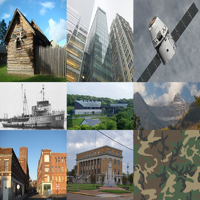
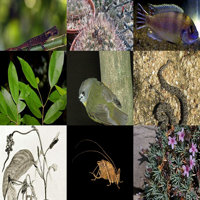
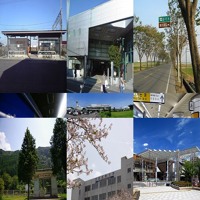
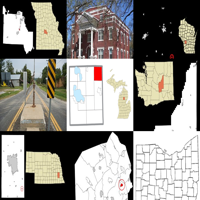
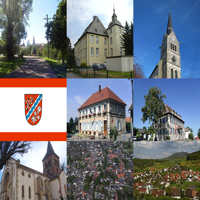
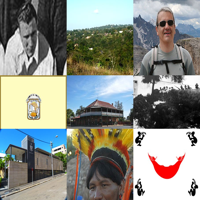
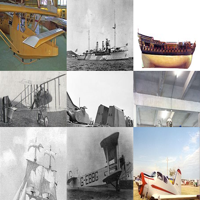


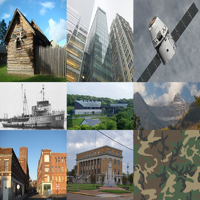
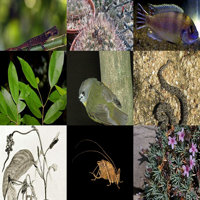
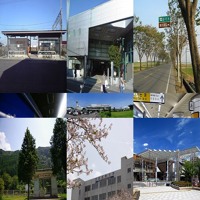
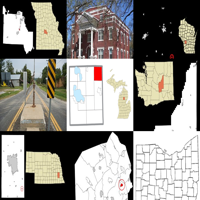
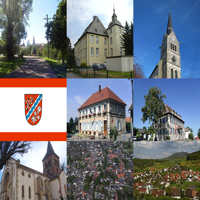
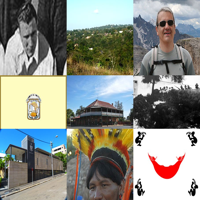
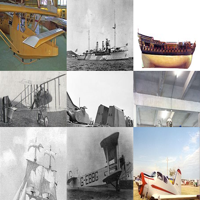

In [69]:
trainer_only_text.model.find_image_represenatives()
trainer_only_text.model.plot_images()